In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
import math
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_curve, auc
pd.set_option("display.max_columns", None)

# Load data

In [2]:
data = pd.read_csv("preprocessed_data.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454282 entries, 0 to 454281
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       454282 non-null  int64  
 1   courier_id                       454282 non-null  int64  
 2   dispatch_time                    454282 non-null  object 
 3   grab_time                        454282 non-null  object 
 4   dt                               454282 non-null  object 
 5   order_id                         454282 non-null  int64  
 6   waybill_id                       454282 non-null  int64  
 7   da_id                            454282 non-null  int64  
 8   is_courier_grabbed               454282 non-null  int64  
 9   is_weekend                       454282 non-null  int64  
 10  is_prebook                       454282 non-null  int64  
 11  dispatch_to_meal_ready_duration  454282 non-null  float64
 12  me

In [3]:
data['dispatch_time'] = pd.to_datetime(data['dispatch_time'])

In [4]:
data["is_courier_grabbed"].sum()/data.shape[0]

0.8971475867412753

In [5]:
data.head()

,Unnamed: 0,courier_id,dispatch_time,grab_time,dt,order_id,waybill_id,da_id,is_courier_grabbed,is_weekend,is_prebook,dispatch_to_meal_ready_duration,meal_prepare_duration,mean_meal_prepare_duration,var_meal_prepare_duration,assigned_to_deadline_duration,courier_area_count,courier_main_area,distance_from_main_area,day_of_week,batch_size,batched_orders,sender_recipient_distance,batch_distance,dispatch_time_of_day,reject_rate_in_last_hour
0,0,0,2022-10-17 00:41:44,1970-01-01 08:00:00,2022-10-17,194804,353538,0,0,0,0,588.0,642.0,557.838710,45122.473118,2236.0,3,0,0.0,Monday,1,[194804],2.853723,2.853723,1,-1.0
1,1,0,2022-10-17 22:26:15,1970-01-01 08:00:00,2022-10-17,104853,366839,0,0,0,0,403.0,443.0,548.974274,20986.856763,2439.0,3,0,0.0,Monday,1,[104853],3.153131,3.153131,5,-1.0
2,2,0,2022-10-17 22:45:15,1970-01-01 08:00:00,2022-10-17,64280,65566,0,0,0,0,1007.0,1057.0,596.980769,224370.254525,2361.0,3,0,0.0,Monday,1,[64280],3.477066,3.477066,5,1.0
3,3,0,2022-10-17 23:02:15,1970-01-01 08:00:00,2022-10-17,86285,88580,0,0,0,0,369.0,436.0,548.974274,20986.856763,1739.0,3,0,0.0,Monday,1,[86285],1.679459,1.679459,5,1.0
4,4,0,2022-10-17 23:03:14,1970-01-01 08:00:00,2022-10-17,83205,432498,0,0,0,0,645.0,1043.0,903.954198,189228.259425,1728.0,3,0,0.0,Monday,1,[83205],1.722458,1.722458,5,1.0


In [6]:
classes = data["is_courier_grabbed"].value_counts()
classes

is_courier_grabbed
1    407558
0     46724
Name: count, dtype: int64

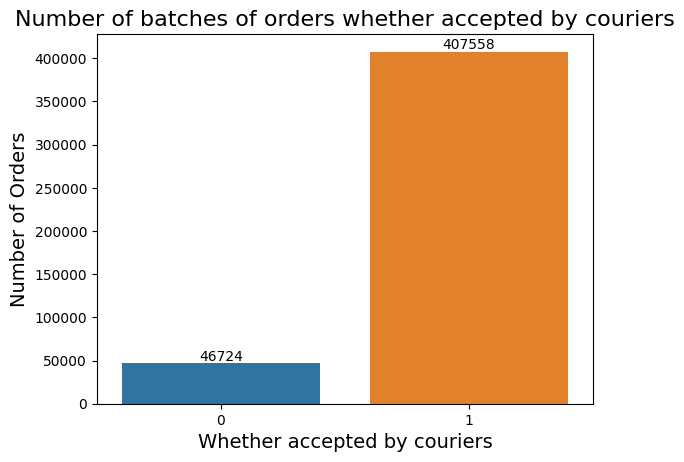

In [7]:
ax = sb.countplot(x='is_courier_grabbed', data=data)
ax.bar_label(ax.containers[0])
plt.title('Number of batches of orders whether accepted by couriers', fontsize=16)
plt.xlabel('Whether accepted by couriers', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks([0, 1])
plt.show()

In [8]:
ax.plot()

[]

In [9]:
pd.crosstab(data["is_courier_grabbed"], data["da_id"])

da_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
is_courier_grabbed,,,,,,,,,,,,,,,,,,,,,,,
0,17421,2412,4617,0,1844,8978,0,0,0,6616,0,0,2038,2723,0,0,0,0,0,0,0,0,75
1,66640,16183,19011,21385,11598,34987,39080,34143,16763,39967,5212,13675,9597,12379,5531,8506,4459,6103,20680,9488,7247,4427,497


# Build predictive model

In [10]:
features = ["dispatch_time_of_day", 
            "courier_area_count", "reject_rate_in_last_hour",
            "var_meal_prepare_duration", 
            "dispatch_to_meal_ready_duration", 
            "assigned_to_deadline_duration", 
            "batch_size", "batch_distance"]


df = data
# df = data[(data["da_id"] == "0") | (data["da_id"] == "1") | 
#           (data["da_id"] == "2") | (data["da_id"] == "4") | 
#           (data["da_id"] == "5") | (data["da_id"] == "9") | 
#           (data["da_id"] == "12") | (data["da_id"] == "13") |
#           (data["da_id"] == "22")]

In [11]:
X = df[features]
y = df["is_courier_grabbed"]

In [12]:
# Split randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# # Split by days
# df_train = df[(df["dispatch_time"].dt.date != pd.to_datetime("2022-10-24").date())]
# df_test = df[(df["dispatch_time"].dt.date == pd.to_datetime("2022-10-24").date())]

# X_train = df_train[features]
# y_train = df_train["is_courier_grabbed"]

# X_test = df_test[features]
# y_test = df_test["is_courier_grabbed"]

## Decision Tree

In [13]:
weights = {0: len(y_train)-sum(y_train), 1: sum(y_train)}
dt_model = DecisionTreeClassifier(class_weight=weights)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 32718, 1: 285279})

### Metrics on train

In [14]:
y_probas = dt_model.predict_proba(X_train)[:,1]
y_preds = (y_probas >= 0.5).astype('int')
y_probas

array([1., 1., 1., ..., 1., 1., 1.])

In [15]:
(tn, fp, fn, tp) = metrics.confusion_matrix(y_train, y_preds).ravel()
metrics.confusion_matrix(y_train, y_preds)

array([[ 32718,      0],
       [     0, 285279]], dtype=int64)

In [16]:
dt_precision_train = tp/(tp + fp)
dt_recall_train = tp/(tp + fn)
dt_specificity_train = tn/(tn + fp)

dt_gmean_train = math.sqrt(dt_recall_train * dt_specificity_train)
dt_f1_train = 2*dt_recall_train*dt_precision_train/(dt_recall_train+dt_precision_train)
dt_accuracy_train = (tp + tn)/(tp + fp + tn + fn)
fpr, tpr, thresholds = roc_curve(y_train, y_probas)
dt_roc_auc_train = auc(fpr, tpr)

### Cross validation

In [17]:
gm_scorer = metrics.make_scorer(geometric_mean_score, greater_is_better=True)
scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring=gm_scorer)
dt_gmean_cv = scores.mean()

In [18]:
scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='roc_auc')
dt_roc_auc_cv = scores.mean()

### Metrics on test

In [19]:
y_probas = dt_model.predict_proba(X_test)[:,1]
y_preds = (y_probas >= 0.5).astype('int')
y_probas

array([1., 1., 1., ..., 1., 1., 1.])

In [20]:
(tn, fp, fn, tp) = metrics.confusion_matrix(y_test, y_preds).ravel()
metrics.confusion_matrix(y_test, y_preds)

array([[  4314,   9692],
       [ 12075, 110204]], dtype=int64)

In [21]:
dt_precision_test = tp/(tp + fp)
dt_recall_test = tp/(tp + fn)
dt_specificity_test = tn/(tn + fp)

dt_gmean_test = math.sqrt(dt_recall_test * dt_specificity_test)
dt_f1_test = 2*dt_recall_test*dt_precision_test/(dt_recall_test+dt_precision_test)
dt_accuracy_test = (tp + tn)/(tp + fp + tn + fn)
dt_fpr, dt_tpr, thresholds = roc_curve(y_test, y_probas)
dt_roc_auc_test = auc(dt_fpr, dt_tpr)

## Random Forest

In [22]:
rf_model = BalancedRandomForestClassifier()
rf_model.fit(X_train, y_train)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to

BalancedRandomForestClassifier()

### Metrics on train

In [23]:
y_probas = rf_model.predict_proba(X_train)[:,1]
y_preds = (y_probas >= 0.5).astype('int')
y_probas

array([1.  , 0.7 , 0.26, ..., 0.98, 0.31, 0.4 ])

In [24]:
(tn, fp, fn, tp) = metrics.confusion_matrix(y_train, y_preds).ravel()
metrics.confusion_matrix(y_train, y_preds)

array([[ 32718,      0],
       [ 78821, 206458]], dtype=int64)

In [25]:
rf_precision_train = tp/(tp + fp)
rf_recall_train = tp/(tp + fn)
rf_specificity_train = tn/(tn + fp)

rf_gmean_train = math.sqrt(rf_recall_train * rf_specificity_train)
rf_f1_train = 2*rf_recall_train*rf_precision_train/(rf_recall_train+rf_precision_train)
rf_accuracy_train = (tp + tn)/(tp + fp + tn + fn)
fpr, tpr, thresholds = roc_curve(y_train, y_probas)
rf_roc_auc_train = auc(fpr, tpr)

### Cross validation

In [26]:
gm_scorer = metrics.make_scorer(geometric_mean_score, greater_is_better=True)
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=gm_scorer)
rf_gmean_cv = scores.mean()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to

In [27]:
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
rf_roc_auc_cv = scores.mean()

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to

### Metrics on test

In [28]:
y_probas = rf_model.predict_proba(X_test)[:,1]
y_preds = (y_probas >= 0.5).astype('int')
y_probas

array([0.84, 1.  , 0.99, ..., 0.36, 0.64, 0.99])

In [29]:
(tn, fp, fn, tp) = metrics.confusion_matrix(y_test, y_preds).ravel()
metrics.confusion_matrix(y_test, y_preds)

array([[11958,  2048],
       [38947, 83332]], dtype=int64)

In [30]:
rf_precision_test = tp/(tp + fp)
rf_recall_test = tp/(tp + fn)
rf_specificity_test = tn/(tn + fp)

rf_gmean_test = math.sqrt(rf_recall_test * rf_specificity_test)
rf_f1_test = 2*rf_recall_test*rf_precision_test/(rf_recall_test+rf_precision_test)
rf_accuracy_test = (tp + tn)/(tp + fp + tn + fn)
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_probas)
rf_roc_auc_test = auc(rf_fpr, rf_tpr)

## XGBoost

In [31]:
neg_per_pos = (len(y_train)-sum(y_train)) / sum(y_train)
neg_per_pos

0.11468772675170623

In [32]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=neg_per_pos)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Metrics on train

In [33]:
y_probas = xgb_model.predict_proba(X_train)[:,1]
y_preds = (y_probas >= 0.5).astype('int')
y_probas

array([0.99780375, 0.6138583 , 0.34741628, ..., 0.99483573, 0.20531087,
       0.33439308], dtype=float32)

In [34]:
(tn, fp, fn, tp) = metrics.confusion_matrix(y_train, y_preds).ravel()
metrics.confusion_matrix(y_train, y_preds)

array([[ 29146,   3572],
       [ 81490, 203789]], dtype=int64)

In [35]:
xgb_precision_train = tp/(tp + fp)
xgb_recall_train = tp/(tp + fn)
xgb_specificity_train = tn/(tn + fp)

xgb_gmean_train = math.sqrt(xgb_recall_train * xgb_specificity_train)
xgb_f1_train = 2*xgb_recall_train*xgb_precision_train/(xgb_recall_train+xgb_precision_train)
xgb_accuracy_train = (tp + tn)/(tp + fp + tn + fn)
fpr, tpr, thresholds = roc_curve(y_train, y_probas)
xgb_roc_auc_train = auc(fpr, tpr)

### Cross validation

In [36]:
gm_scorer = metrics.make_scorer(geometric_mean_score, greater_is_better=True)
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring=gm_scorer)
xgb_gmean_cv = scores.mean()

In [37]:
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
xgb_roc_auc_cv = scores.mean()

### Metrics on test

In [38]:
y_probas = xgb_model.predict_proba(X_test)[:,1]
y_preds = (y_probas >= 0.5).astype('int')
y_probas

array([0.925041  , 0.99600804, 0.9203835 , ..., 0.31892794, 0.5616797 ,
       0.9912375 ], dtype=float32)

In [39]:
(tn, fp, fn, tp) = metrics.confusion_matrix(y_test, y_preds).ravel()
metrics.confusion_matrix(y_test, y_preds)

array([[11627,  2379],
       [35771, 86508]], dtype=int64)

In [40]:
xgb_precision_test = tp/(tp + fp)
xgb_recall_test = tp/(tp + fn)
xgb_specificity_test = tn/(tn + fp)

xgb_gmean_test = math.sqrt(xgb_recall_test * xgb_specificity_test)
xgb_f1_test = 2*xgb_recall_test*xgb_precision_test/(xgb_recall_test+xgb_precision_test)
xgb_accuracy_test = (tp + tn)/(tp + fp + tn + fn)
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, y_probas)
xgb_roc_auc_test = auc(xgb_fpr, xgb_tpr)

## SMOTE + XGB

In [41]:
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X_train, y_train)

over_X_train, over_y_train = over_X, over_y
over_X_test, over_y_test = X_test, y_test

In [42]:
smote_xgb_model = xgb.XGBClassifier()
smote_xgb_model.fit(over_X_train, over_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Metrics on train

In [43]:
y_probas = smote_xgb_model.predict_proba(over_X_train)[:,1]
y_preds = (y_probas >= 0.5).astype('int')
y_probas

array([0.99886394, 0.88575256, 0.8399492 , ..., 0.8586093 , 0.00916479,
       0.0033316 ], dtype=float32)

In [44]:
(tn, fp, fn, tp) = metrics.confusion_matrix(over_y_train, y_preds).ravel()
metrics.confusion_matrix(over_y_train, y_preds)

array([[242367,  42912],
       [ 24537, 260742]], dtype=int64)

In [45]:
smote_xgb_precision_train = tp/(tp + fp)
smote_xgb_recall_train = tp/(tp + fn)
smote_xgb_specificity_train = tn/(tn + fp)

smote_xgb_gmean_train = math.sqrt(smote_xgb_recall_train * smote_xgb_specificity_train)
smote_xgb_f1_train = 2*smote_xgb_recall_train*smote_xgb_precision_train/(smote_xgb_recall_train+smote_xgb_precision_train)
smote_xgb_accuracy_train = (tp + tn)/(tp + fp + tn + fn)
fpr, tpr, thresholds = roc_curve(over_y_train, y_probas)
smote_xgb_roc_auc_train = auc(fpr, tpr)

### Cross validation

In [46]:
gm_scorer = metrics.make_scorer(geometric_mean_score, greater_is_better=True)
scores = cross_val_score(smote_xgb_model, over_X_train, over_y_train, cv=5, scoring=gm_scorer)
smote_xgb_gmean_cv = scores.mean()

In [47]:
scores = cross_val_score(smote_xgb_model, over_X_train, over_y_train, cv=5, scoring='roc_auc')
smote_xgb_roc_auc_cv = scores.mean()

### Metrics on test

In [48]:
y_probas = smote_xgb_model.predict_proba(over_X_test)[:,1]
y_preds = (y_probas >= 0.5).astype('int')
y_probas

array([0.9823934 , 0.99669313, 0.9282998 , ..., 0.46777505, 0.91937315,
       0.99670947], dtype=float32)

In [49]:
(tn, fp, fn, tp) = metrics.confusion_matrix(over_y_test, y_preds).ravel()
metrics.confusion_matrix(over_y_test, y_preds)

array([[  5644,   8362],
       [ 11247, 111032]], dtype=int64)

In [50]:
smote_xgb_precision_test = tp/(tp + fp)
smote_xgb_recall_test = tp/(tp + fn)
smote_xgb_specificity_test = tn/(tn + fp)

smote_xgb_gmean_test = math.sqrt(smote_xgb_recall_test * smote_xgb_specificity_test)
smote_xgb_f1_test = 2*smote_xgb_recall_test*smote_xgb_precision_test/(smote_xgb_recall_test+smote_xgb_precision_test)
smote_xgb_accuracy_test = (tp + tn)/(tp + fp + tn + fn)
smote_xgb_fpr, smote_xgb_tpr, thresholds = roc_curve(over_y_test, y_probas)
smote_xgb_roc_auc_test = auc(smote_xgb_fpr, smote_xgb_tpr)

# Model Evaluation

## Performance

In [51]:
eval_arr = [[dt_gmean_train, dt_roc_auc_train, dt_gmean_cv, dt_roc_auc_cv, dt_gmean_test, dt_roc_auc_test],
            [rf_gmean_train, rf_roc_auc_train, rf_gmean_cv, rf_roc_auc_cv, rf_gmean_test, rf_roc_auc_test],
            [xgb_gmean_train, xgb_roc_auc_train, xgb_gmean_cv, xgb_roc_auc_cv, xgb_gmean_test, xgb_roc_auc_test],
            [smote_xgb_gmean_train, smote_xgb_roc_auc_train, smote_xgb_gmean_cv, smote_xgb_roc_auc_cv, smote_xgb_gmean_test, smote_xgb_roc_auc_test]]

columns = pd.MultiIndex.from_product(
    [["Train", "CV", "Test"], ["G-mean", "ROC AUC"]],
    names=["Set", "Metric"]
)

index = ["Decision Tree", "Random Forest", "XGBoost", "SMOTE+XGB"]

eval_df = pd.DataFrame(eval_arr, columns=columns, index=index)

eval_df

Set               Train                  CV                Test          
Metric           G-mean   ROC AUC    G-mean   ROC AUC    G-mean   ROC AUC
Decision Tree  1.000000  1.000000  0.527350  0.606748  0.526873  0.604631
Random Forest  0.850709  0.991596  0.758007  0.849039  0.762785  0.849412
XGBoost        0.797722  0.884796  0.763750  0.853136  0.766353  0.853231
SMOTE+XGB      0.881196  0.961123  0.861595  0.953972  0.604901  0.830997

In [52]:
def convert_to_percentage(value):
    try:
        return round(float(value) * 100, 2)
    except ValueError:
        return value

pct_eval_df = eval_df.applymap(convert_to_percentage)
pct_eval_df

Set             Train             CV           Test        
Metric         G-mean ROC AUC G-mean ROC AUC G-mean ROC AUC
Decision Tree  100.00  100.00  52.73   60.67  52.69   60.46
Random Forest   85.07   99.16  75.80   84.90  76.28   84.94
XGBoost         79.77   88.48  76.37   85.31  76.64   85.32
SMOTE+XGB       88.12   96.11  86.16   95.40  60.49   83.10

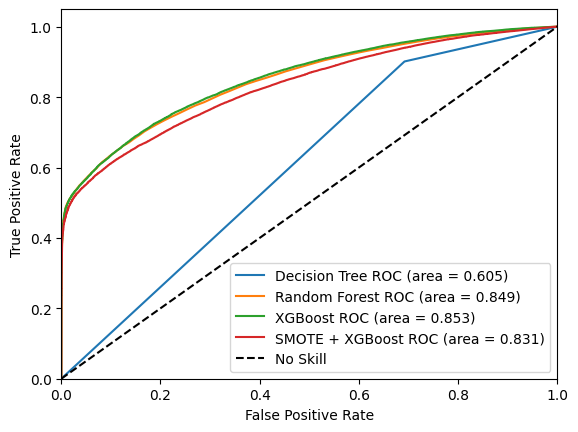

In [53]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probas) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(dt_fpr, dt_tpr, label='Decision Tree ROC (area = %0.3f)' % dt_roc_auc_test)
plt.plot(rf_fpr, rf_tpr, label='Random Forest ROC (area = %0.3f)' % rf_roc_auc_test)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost ROC (area = %0.3f)' % xgb_roc_auc_test)
plt.plot(smote_xgb_fpr, smote_xgb_tpr, label='SMOTE + XGBoost ROC (area = %0.3f)' % smote_xgb_roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Robustness

Compare again with different splitting

# Parameter tuning

In [54]:
X = df[features]
y = df["is_courier_grabbed"]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [56]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators': stats.randint(50, 200),
    'scale_pos_weight': stats.uniform(0.01, 1.0)
    
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=30, cv=5, scoring='roc_auc')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.08927236629802508, 'max_depth': 6, 'n_estimators': 143, 'scale_pos_weight': 0.8036095865587232, 'subsample': 0.7965782530417181}
Best score:  0.8560998486153322


In [57]:
for param in random_search.best_params_:
    print(param + "=" + str(random_search.best_params_[param]) + ",")

learning_rate=0.08927236629802508,
max_depth=6,
n_estimators=143,
scale_pos_weight=0.8036095865587232,
subsample=0.7965782530417181,


# Retrain the chosen model with full dataset and optimized parameters

In [58]:
X = df[features]
y = df["is_courier_grabbed"]

In [59]:
chosen_model = xgb.XGBClassifier(learning_rate=0.06383990156291175,
                                max_depth=7,
                                n_estimators=137,
                                scale_pos_weight=0.703939097208381,
                                subsample=0.7142673037989742)
chosen_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06383990156291175,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=137, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
y_probas = chosen_model.predict_proba(X)
y_preds = (y_probas [:,1] >= 0.5).astype('int')

In [61]:
(tn, fp, fn, tp) = metrics.confusion_matrix(y_preds, y).ravel()
metrics.confusion_matrix(y_preds, y)

array([[ 10619,   7895],
       [ 36105, 399663]], dtype=int64)

In [62]:
roc_auc = metrics.roc_auc_score(y_preds, y)
roc_auc

0.7453561148817872

In [63]:
chosen_model.save_model("predictor.json")